# **Where should I get a beer in Portland Oregon?**
## **Capstone Project - The Battle of Neighborhoods**
##### By Peter J. Lindner, Ph.D.

Now that you have been equipped with the skills and the tools to use location data to explore a geographical location, over the course of two weeks, you will have the opportunity to be as creative as you want and come up with an idea to leverage the Foursquare location data to explore or compare neighborhoods or cities of your choice or to come up with a problem that you can use the Foursquare location data to solve.

## **Problem Statement:**  In Portland, OR where should I go to explore the local breweries?

**1.  A description of the problem and a discussion of the background:**  Portland Oregon has been regularly ranked as one of the best beer cities in the world(i.e. [Readers Digest, 2019](https://www.readersdigest.ca/travel/world/10-best-beer-cities-world/), [Oregonian, 2018](https://www.oregonlive.com/life-and-culture/erry-2018/12/5f7c2b69628468/portland-named-best-us-city-fo.html), [SmartAsset, 2019](https://smartasset.com/checking-account/best-cities-for-beer-drinkers-2019?cjevent=bbedf5f02a7e11ea805600c50a1c0e0b&utm_source=cj&utm_medium=cpc&utm_campaign=cj__falc_test_1&utm_content=Skimlinks&utm_term=Follow+This+Link)).  The city though is quite large at 145 square miles, and has many bars (>300, ~ 45 per 10,000 residence) and breweries (~100).   This study aims to determine if a person was visiting Portland Oregon for the day, what are the best locations to experience the Portland Beer-scene?

This problem can be used for a tour-guide business, travel planning company, or just for individuals to find a good place to visit.  I also plan to test this on an additional US city.

**2. A description of the data and how it will be used to solve the problem. (15 marks):**  Using foursquare I plan to identify the location of the venues with the category "Brewery".  With these locations identified, I will then use DBSCAN to cluster them, varying epsilon to determine an ideal distance.  A minimum of 3 Breweries will be used to forma  cluster.  I also plan to determine an ideal value of epsilon.  This program will in the end allow a user to determine where to go to see the most of Portland's Beer-scene with the shortest amount of travel.

In [1]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Make a dataframe from FourSquare of Brewery, Brewpubs, etc.

In [3]:
address = 'Portland'

geolocator = Nominatim(user_agent="Portland_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Portland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Portland are 45.5202471, -122.6741949.


This is the center of downtown Portland.  Very close, but the geographic middle is 45.524190 -122.637300

In [4]:
latitude = 45.524190
longitude = -122.637300

Category id for:
* Brewery is 50327c8591d4c4b30a586d5d
* Beer garden is 4bf58dd8d48988d117941735

https://developer.foursquare.com/docs/resources/categories

In [5]:
CLIENT_ID = '23CV1SKWTESEYTSKVVOS5MG5RE2X5PZ5BTYVJEDRNOJONGAH' # your Foursquare ID
CLIENT_SECRET = 'SOP0UXDMPOZEFDO2TNSEWAQRTMGMYM5ZJWGU1KSDOFE0SSPR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
CATEGORY_ID = '50327c8591d4c4b30a586d5d'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
print('CATEGORY_ID:' + CATEGORY_ID)

Your credentails:
CLIENT_ID: 23CV1SKWTESEYTSKVVOS5MG5RE2X5PZ5BTYVJEDRNOJONGAH
CLIENT_SECRET:SOP0UXDMPOZEFDO2TNSEWAQRTMGMYM5ZJWGU1KSDOFE0SSPR
CATEGORY_ID:50327c8591d4c4b30a586d5d


In [6]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 8000 # define radius (8000meters ~ 5 miles)
 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    CATEGORY_ID
)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=23CV1SKWTESEYTSKVVOS5MG5RE2X5PZ5BTYVJEDRNOJONGAH&client_secret=SOP0UXDMPOZEFDO2TNSEWAQRTMGMYM5ZJWGU1KSDOFE0SSPR&v=20180605&ll=45.52419,-122.6373&radius=8000&limit=1000&categoryId=50327c8591d4c4b30a586d5d'

In [7]:
results = requests.get(url).json()

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Cascade Brewing Barrel House,Brewery,45.516603,-122.655837
1,Base Camp Brewing,Brewery,45.519896,-122.656464
2,Deschutes Brewery Portland Public House,Brewery,45.524544,-122.681982
3,Culmination Brewing,Brewery,45.528877,-122.643690
4,Hair of the Dog Brewery & Tasting Room,Brewery,45.515866,-122.665682
5,Hopworks Urban Brewery,Brewery,45.496928,-122.634908
6,Modern Times Belmont Fermentorium,Brewery,45.516346,-122.659457
7,Fire on the Mountain,Brewery,45.522803,-122.648332
8,Wayfinder Beer,Brewery,45.520562,-122.663460
9,Migration Brewing,Brewery,45.526289,-122.636384


In [10]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

99 venues were returned by Foursquare.


In [11]:
unique_venues = nearby_venues.categories.unique()

In [12]:
print(unique_venues)

['Brewery' 'Pub' 'Bar' 'American Restaurant' 'Distillery' 'Pizza Place'
 'Lounge' 'Burger Joint' 'BBQ Joint']


In [13]:
Breweries = nearby_venues

In [14]:
Breweries.head()

,name,categories,lat,lng
0,Cascade Brewing Barrel House,Brewery,45.516603,-122.655837
1,Base Camp Brewing,Brewery,45.519896,-122.656464
2,Deschutes Brewery Portland Public House,Brewery,45.524544,-122.681982
3,Culmination Brewing,Brewery,45.528877,-122.643690
4,Hair of the Dog Brewery & Tasting Room,Brewery,45.515866,-122.665682


### Map the locations of the venues in Portland, Oregon

In [15]:
# create map of Portland with Breweries using latitude and longitude values
map_Portland = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name, cat in zip(Breweries['lat'], Breweries['lng'], Breweries['name'], Breweries['categories']):
    label = '{}'.format(name) #'{}, {}'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Portland)  
    
map_Portland

### Cluster the data based on DBSCAN Clustering

In [16]:
X = Breweries.drop(['name','categories'], axis = 1).values

In [17]:
type(X)

numpy.ndarray

In [18]:
epsilon = .1
minimumSamples = 3

In [19]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_+2
Breweries["Clus_DB"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

# A sample of clusters
Breweries[["name","categories","lat","lng","Clus_DB"]].head(5)

,name,categories,lat,lng,Clus_DB
0,Cascade Brewing Barrel House,Brewery,45.516603,-122.655837,2
1,Base Camp Brewing,Brewery,45.519896,-122.656464,1
2,Deschutes Brewery Portland Public House,Brewery,45.524544,-122.681982,3
3,Culmination Brewing,Brewery,45.528877,-122.643690,1
4,Hair of the Dog Brewery & Tasting Room,Brewery,45.515866,-122.665682,1


In [20]:
set(labels)

{1, 2, 3, 4, 5}

In [21]:
num_cluster= max(set(labels))

In [22]:
# create map of Portland with Breweries using latitude and longitude values
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(num_cluster)
ys = [i + x + (i*x)**2 for i in range(num_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map  
markers_colors = []
for lat, lng, name, cat, cluster in zip(Breweries['lat'], Breweries['lng'], Breweries['name'], Breweries['categories'], Breweries['Clus_DB']):
    #label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    label = '{}, {}'.format(name, cluster) #'{}, {}'.format(name, cat)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.8).add_to(map_clusters)   
    
map_clusters

In [23]:
Breweries.loc[Breweries['Clus_DB'] == 2, Breweries.columns[[0]]]

,name
0,Cascade Brewing Barrel House
6,Modern Times Belmont Fermentorium
16,Schilling Cider House Portland
28,Rogue Eastside Pub & Pilot Brewery


In [24]:
Breweries.loc[Breweries['Clus_DB'] == 3, Breweries.columns[[0]]]

,name
2,Deschutes Brewery Portland Public House
20,Rogue Ales Public House & Distillery
27,Von Ebert Brewing
29,10 Barrel Brewing
47,Back Pedal Brewing
56,Backwoods Brewing Company
74,McMenamins Mission Theater
78,Splash Bar & Brewing
91,10 Barrel Rooftop
92,Little Big Burger


In [25]:
Breweries.loc[Breweries['Clus_DB'] == 4, Breweries.columns[[0]]]

,name
13,Grixsen Brewing Company
23,Baerlic Brewing
83,Ladd Taphouse
86,Vagabond Brewing PDX


In [26]:
Breweries.loc[Breweries['Clus_DB'] == 5, Breweries.columns[[0]]]

,name
57,Lucky Labrador Brew Pub
71,Eastside Distilling
82,Away Days Brewing


### Determine the ideal epsilon value for DBSCAN

To determine the ideal value of epsilon we want to detrmine the 

https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

In [27]:
from sklearn.neighbors import NearestNeighbors

In [28]:
import matplotlib.pyplot as plt

In [29]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

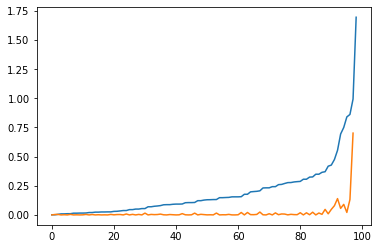

In [30]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.plot(np.diff(distances))

(80, 100, 0, 0.6)

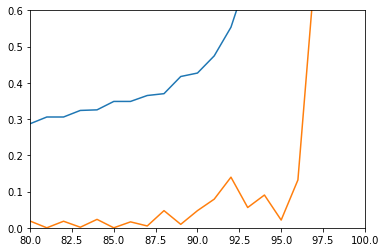

In [31]:
plt.plot(distances)
plt.plot(np.diff(distances))
plt.axis((80,100,0,0.6))

(90, 93, 0.0, 0.2)

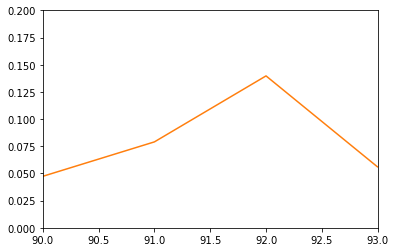

In [32]:
plt.plot(distances)
plt.plot(np.diff(distances))
plt.axis((90,93,0.,.2))

Largest change in epsilon occurs at a x value of 92.0

(90, 93, 0.4, 0.6)

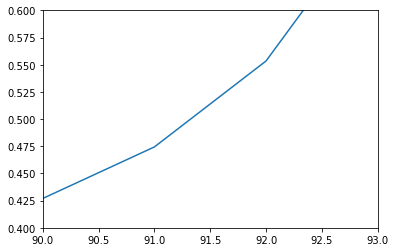

In [33]:
plt.plot(distances)
plt.plot(np.diff(distances))
plt.axis((90,93,0.4,.6))

x value of 92 corresponds to a epsilon distance of 0.550

In [34]:
epsilon_Ideal = .550
minimumSamples = 3

In [35]:
# Compute DBSCAN
db = DBSCAN(eps=epsilon_Ideal, min_samples=minimumSamples).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_+2
Breweries["Clus_DB"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

# A sample of clusters
Breweries[["name","categories","lat","lng","Clus_DB"]].head(5)

,name,categories,lat,lng,Clus_DB
0,Cascade Brewing Barrel House,Brewery,45.516603,-122.655837,2
1,Base Camp Brewing,Brewery,45.519896,-122.656464,2
2,Deschutes Brewery Portland Public House,Brewery,45.524544,-122.681982,2
3,Culmination Brewing,Brewery,45.528877,-122.643690,2
4,Hair of the Dog Brewery & Tasting Room,Brewery,45.515866,-122.665682,2


In [36]:
# create map of Portland with Breweries using latitude and longitude values
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(num_cluster)
ys = [i + x + (i*x)**2 for i in range(num_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map  
markers_colors = []
for lat, lng, name, cat, cluster in zip(Breweries['lat'], Breweries['lng'], Breweries['name'], Breweries['categories'], Breweries['Clus_DB']):
    #label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    label = '{}, {}'.format(name, cluster) #'{}, {}'.format(name, cat)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.8).add_to(map_clusters)   
    
map_clusters

This may show the ideal clustering from a mathematical standpoint, but from acutal travel a value for epsilon of 0.1 seems to give a more practical answer.  For this model the ideal selection will not be used.

###  Testing alternate city: Portland Maine vs. Portland Oregon

In [37]:
address = 'Portland, Maine'

geolocator = Nominatim(user_agent="Portland_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Portland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Portland are 43.6610277, -70.2548596.


In [38]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 8000 # define radius (8000meters ~ 5 miles)
 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    CATEGORY_ID
)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=23CV1SKWTESEYTSKVVOS5MG5RE2X5PZ5BTYVJEDRNOJONGAH&client_secret=SOP0UXDMPOZEFDO2TNSEWAQRTMGMYM5ZJWGU1KSDOFE0SSPR&v=20180605&ll=43.6610277,-70.2548596&radius=8000&limit=1000&categoryId=50327c8591d4c4b30a586d5d'

In [39]:
results = requests.get(url).json()

In [40]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [41]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)

,name,categories,lat,lng
0,Rising Tide Brewing Company,Brewery,43.665431,-70.257091
1,Oxbow Blending and Bottling,Brewery,43.664935,-70.251287
2,Austin Street Brewery,Brewery,43.665080,-70.257582
3,The Shipyard Brewing Company,Brewery,43.661807,-70.247901
4,Portland Mash Tun,Brewery,43.656106,-70.254022
5,Lone Pine Brewing,Brewery,43.670050,-70.255966
6,Goodfire Brewing Company,Brewery,43.670218,-70.255972
7,Urban Farm Fermentory,Brewery,43.669089,-70.256050
8,Bissell Brothers Brewing Co,Brewery,43.650927,-70.292227
9,Foulmouthed Brewing,Brewery,43.640943,-70.255085


In [42]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

29 venues were returned by Foursquare.


In [43]:
Breweries = nearby_venues
X = Breweries.drop(['name','categories'], axis = 1).values

In [44]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_+2
Breweries["Clus_DB"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

# A sample of clusters
Breweries[["name","categories","lat","lng","Clus_DB"]].head(5)

,name,categories,lat,lng,Clus_DB
0,Rising Tide Brewing Company,Brewery,43.665431,-70.257091,1
1,Oxbow Blending and Bottling,Brewery,43.664935,-70.251287,1
2,Austin Street Brewery,Brewery,43.665080,-70.257582,1
3,The Shipyard Brewing Company,Brewery,43.661807,-70.247901,1
4,Portland Mash Tun,Brewery,43.656106,-70.254022,2


In [45]:
# create map of Portland with Breweries using latitude and longitude values
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(num_cluster)
ys = [i + x + (i*x)**2 for i in range(num_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map  
markers_colors = []
for lat, lng, name, cat, cluster in zip(Breweries['lat'], Breweries['lng'], Breweries['name'], Breweries['categories'], Breweries['Clus_DB']):
    #label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    label = '{}, {}'.format(name, cluster) #'{}, {}'.format(name, cat)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.8).add_to(map_clusters)   
    
map_clusters

In [46]:
Breweries.loc[Breweries['Clus_DB'] == 2, Breweries.columns[[0]]]

,name
4,Portland Mash Tun
12,Liquid Riot Bottling Company
17,Gritty McDuffs Brewing Company
18,Sweetgrass Farm Wine & Distillery
24,The Portland Beer Hub
26,Maine Beer Tours


In [47]:
Breweries.loc[Breweries['Clus_DB'] == 3, Breweries.columns[[0]]]

,name
5,Lone Pine Brewing
6,Goodfire Brewing Company
7,Urban Farm Fermentory
27,Brewery Extrava


In [48]:
Breweries.loc[Breweries['Clus_DB'] == 4, Breweries.columns[[0]]]

,name
11,Allagash Brewing Company
14,Foundation Brewing Company
16,Austin Street Brewery
20,Definitive Brewing Company
23,Battery Steele Brewing


Portland Maine has fewer breweries than as Portland Oregon, at 29 vs. 99 (for a 5 mile radius).  Portland Maine still has a few key clusters of breweries to be able to easily experience the Portland Maine beer-scene.  